# Virtual Captive Tests (VCT)
A dataset from a Virtual Captive Test (VCT) (see {numref}`reference_frame`) is used to highlight the problem with multicollinearity in linear regression.
Bayesian inference with informative priors are explored as a way to mitigate this problem.

```{figure} reference_frame.png
---
name: reference_frame
---
Drift angle test - measuring the forces at a certain speed and drift angle.
```

![](reference_frame.png)

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
# Import pyMC3 and also arviz for visualisation
import pymc as pm
import arviz as az
import sympy as sp
import pandas as pd
import numpy as np
import statsmodels.api as sm


import symseaman as ss
from symseaman.substitute_dynamic_symbols import lambdify, remove_bis_eq, run, standard_substitutes
from symseaman.seaman_symbols import *
from vct.bis_system import BisSystem

[03/27/23 17:29:09] WARNING  Using NumPy C-API based implementation for BLAS functions.        ]8;id=858710;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/pytensor/tensor/blas_headers.py\blas_headers.py]8;;\:]8;id=556564;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/pytensor/tensor/blas_headers.py#1016\1016]8;;\

In [3]:
import sympy as sp
from symseaman.seaman_symbols import *
from symseaman.substitute_dynamic_symbols import run, lambdify, standard_substitutes, remove_bis, remove_bis_eq, standard_substitutes_eq, lower_and_abs
from symseaman.seaman_symbol import BisSymbol
import symseaman as ss
from symseaman.seaman_symbol import expand_bis
from symseaman.shipdict import ShipDict
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
pd.set_option('max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = 9,7
#plt.style.use('bmh')
import vct.bokeh_plotting as bokeh_plotting
from numpy.testing import assert_almost_equal
from scipy.interpolate import interp1d
from symseaman.calculate import calculate_ship
from symseaman.to_matrix import matrix_form, matrix_form_standard, exclude, exclude_derivatives
from functools import reduce
from operator import add
from vct.regression_ols import Regression, RegressionPipeline
import dill
import seaborn as sns
from myst_nb import glue

Loading BokehJS ...

In [4]:
# Read configs:
import anyconfig
globals_path = "../../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]
from vct.bis_system import BisSystem
import statsmodels.api as sm
from scipy.stats import norm
from vct.regression_ols import data_to_bis
from scipy.stats import norm, multivariate_normal
from regression_ols import fit

import matplotlib.pyplot as plt
plt.style.use('jupyter')
#az.style.use("arviz-grayscale")

In [5]:
%reload_kedro
ship_name=ships[0]
shipdict = catalog.load(f"{ship_name}.shipdict_base")
ship_dict_from_regression = catalog.load(f"{ ship_name }.ship_dict_from_regression")

df_VCT = catalog.load(f"{ship_name}.df_VCT")
df_VCT['g'] = df_VCT['g'].fillna(method='pad')
df_VCT['rho'] = df_VCT['rho'].fillna(method='pad')
df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])

df_VCT['fx_hull'] = df_VCT['fx']  # Not true but works for this example...
df_VCT['fy_hull'] = df_VCT['fy']  # Not true but works for this example...
df_VCT['mz_hull'] = df_VCT['mz']  # Not true but works for this example...

thrust_keys = catalog.load(f"params:{ship_name}.thrust_keys")

if len(thrust_keys) > 0:
    df_VCT['tprop'] = df_VCT[thrust_keys[0]]
else:
    df_VCT['tprop'] = 0
    thrust_keys=['tprop']
    
derivatives = catalog.load(f"{ship_name}.derivatives")["OLS"]
derivatives_std = catalog.load(f"{ship_name}.derivatives_std")["OLS"]

[03/27/23 17:29:23] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=604648;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=808616;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[03/27/23 17:29:25] INFO     Kedro project phd                                                      ]8;id=436233;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=149948;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=854559;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=148987;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from 'M5064-02-A.shipdict_base' (ShipDictDataSet)...  ]8;id=792360;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=680522;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'M5064-02-A.ship_dict_from_regression'           ]8;id=858421;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=477486;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (IncrementalDataSet)...                                                               

                    INFO     Loading data from 'M5064-02-A.df_VCT' (CSVDataSet)...              ]8;id=101735;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=877758;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:M5064-02-A.thrust_keys'                  ]8;id=475615;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=13275;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'M5064-02-A.derivatives' (IncrementalDataSet)... ]8;id=92706;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=939261;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'M5064-02-A.derivatives_std'                     ]8;id=748340;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=488051;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (IncrementalDataSet)...                                                               

```{glue:figure} vct_drift
:name: "vct_drift"

Transverse force from drift angle variations with VCT for two ship speeds.
```

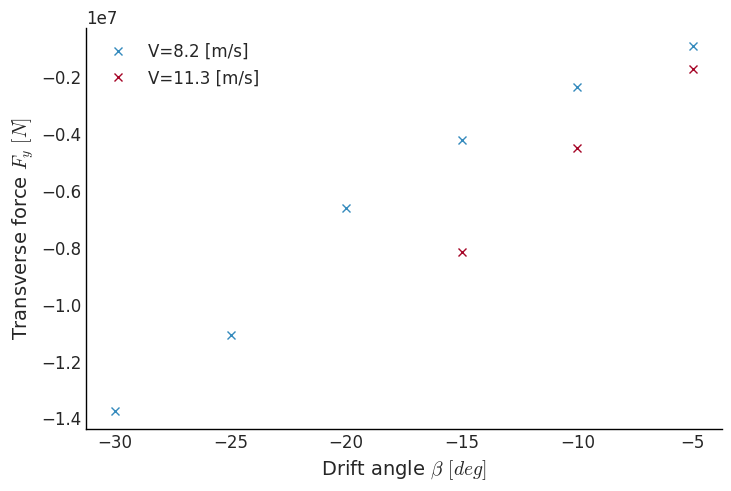

In [6]:
df_ = df_VCT.groupby(by='test type').get_group('Drift angle')
fig,ax=plt.subplots()
for V_, group in df_.groupby(by='V'):
    group.plot(x='beta_deg', y='fy', style='x', label=f"V={np.round(V_,decimals=1)} [m/s]", ax=ax)
ax.set_xlabel(r'Drift angle $\beta$ $[deg]$')
ax.set_ylabel(r'Transverse force $F_y$ $[N]$');
glue("vct_drift",fig, display=False)

A model to describe the transverse force as function of: the longitudinal speed $u$ and transverse speed $v$ together with the hydrodynamic derivatives (parameters) $Y_{v|v|}$, $Y_{uv}$, and $Y_{uuv}$:

```{glue:math} eqsway
:name: "eqsway"
```

In [7]:
eq = ss.equations.hull.sway.eq_expanded.subs([
    (phi.bis,0),
    (r_w.bis,0),
    (delta,0),
    #(Y_uuv,0), # Note!
    (Y_h.bis, 'F_y'),
    (u_w.bis, 'u'),
    (v_w.bis, 'v'),
    
    ])
glue("eqsway",remove_bis_eq(eq))

Eq(F_y, Y_{v|v|}*v*Abs(v) + u*v*(Y_uuv*u + Y_uv))

### Regression

In [8]:
pipeline, df_bis = fit(df_VCT=df_VCT, shipdict=shipdict)
pre_set_derivatives_0 = {}
regression = pipeline['drift']

In [9]:
regression.eq_excluded

Eq(Y_h, Y_uuv*u_w**2*v_w + Y_uv*u_w*v_w + Y_{v|v|}*v_w*Abs(v_w))

In [10]:
pre_set_derivatives_0 = {}
y,X=regression.label_and_features(derivatives=pre_set_derivatives_0, meta_data=pipeline.meta_data)

Estimation of the hydrodynamic derivatives can be formulated as a linear regression problem:
```{math}
:label: regression
y = X \beta + \epsilon
```

Tthe feature matrix $X$ contains polynomials of the state ($u$ and $v$ here) namely: $u^2 \cdot v$, $u \cdot v$, and $v \cdot |v|$ as given in the following table:

```{glue:figure} features
:name: "features"

Feature matrix $X$.
```

In [11]:
glue("features",X.style.hide_index())

yuv,yvav,yuuv
-0.002672,-0.000234,-0.000467
-0.005263,-0.000928,-0.000909
-0.007693,-0.002061,-0.001304
-0.009890,-0.003600,-0.001630
-0.011787,-0.005496,-0.001874
-0.013325,-0.007693,-0.002024
-0.005052,-0.000442,-0.001214
-0.009950,-0.001754,-0.002363
-0.014545,-0.003897,-0.003389


In [12]:
eq = ss.equations.hull.sway.eq_expanded.subs([
    (phi.bis,0),
    (r_w.bis,0),
    (delta,0),
    #(Y_uuv,0), # Note!
    
    ])
eq

Eq(Y''_h, u''_w*v''_w*(u''_w*Y_uuv + Y_uv) + v''_w*Y_{v|v|}*Abs(v''_w))

In [13]:
lambda_sway = lambdify(eq, convert_to_SI=True)

In [14]:
df_ = df_VCT.groupby(by='test type').get_group('Drift angle')
df_predict = df_.copy()
df_predict['fy_ols'] = run(function=lambda_sway, inputs=df_, l=shipdict.main_data['l'], disp=shipdict.design_particulars['disp'], **regression.regression.params)

```{glue:figure} ols_regression
:name: "ols_regression"

Fitted model with multiple ordinary least square (OLS) regression.
```

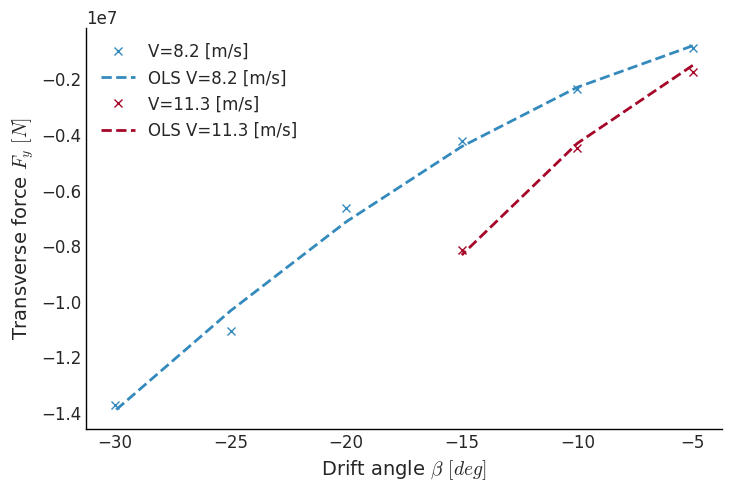

In [15]:
fig,ax=plt.subplots()
for V_, group in df_predict.groupby(by='V'):
    plot = group.plot(x='beta_deg', y='fy', style='x', label=f"V={np.round(V_,decimals=1)} [m/s]", ax=ax)
    color = plot.lines[-1].get_color()
    group.plot(x='beta_deg', y='fy_ols', style='--', color=color, label=f"OLS V={np.round(V_,decimals=1)} [m/s]", zorder=-10, ax=ax)

    ax.set_xlabel(r'Drift angle $\beta$ $[deg]$')
ax.set_ylabel(r'Transverse force $F_y$ $[N]$');
glue("ols_regression",fig, display=False)

The regressed model seems to fit the data reasonably well - as seen in {numref}`ols_regression`. There is however high [**multicollinearity**](https://en.wikipedia.org/wiki/Multicollinearity) in this model, with high correlation between the features associated with each derivative as seen in {numref}`pairplot` and {numref}`corr`. 

```{glue:figure} pairplot
:name: "pairplot"

There is a high correlation between the features associated with each derivative.
```

```{glue:figure} corr
:name: "corr"

There is a high correlation between the features associated with each derivative.
```

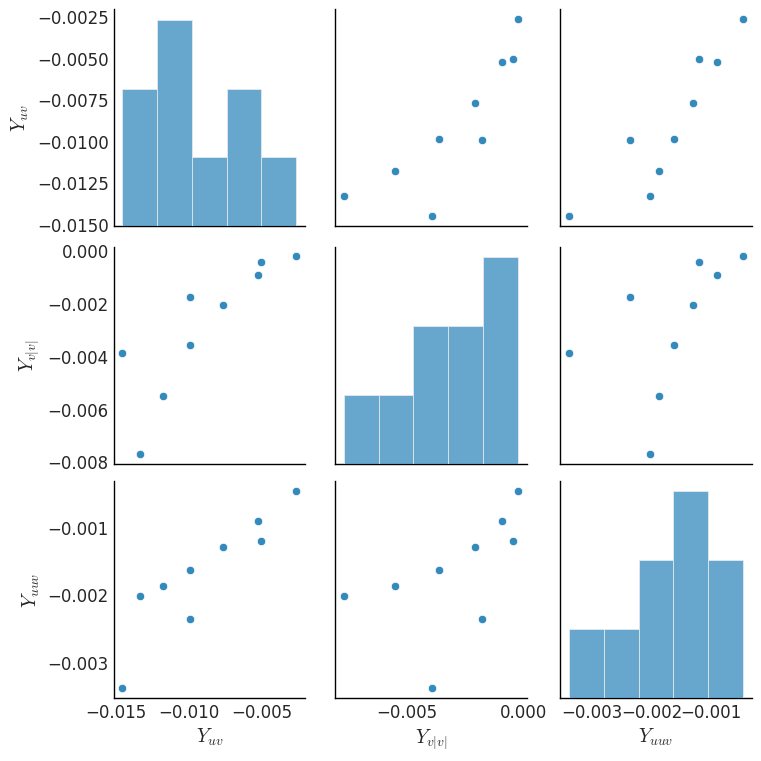

In [16]:
columns_sympy = {
    'yuv':Y_uv,
    'yuuv':Y_uuv,
    'yvav':Y_vav,
}
columns_latex = {key:f"${sp.latex(value)}$" for key,value in columns_sympy.items()}
X_ = X.copy()
X_.rename(columns=columns_latex, index=columns_latex, inplace=True)
grid = sns.pairplot(data=X_)
glue("pairplot",grid.fig, display=False)

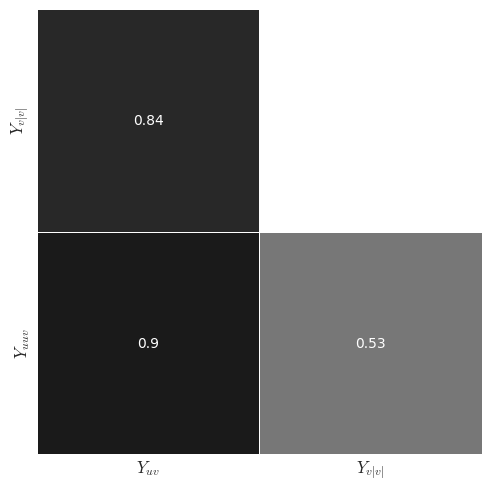

In [17]:
import matplotlib as mpl

corr = X.corr()

columns_sympy = {
    'yuv':Y_uv,
    'yuuv':Y_uuv,
    'yvav':Y_vav,
}
columns_latex = {key:f"${sp.latex(value)}$" for key,value in columns_sympy.items()}
corr.rename(columns=columns_latex, index=columns_latex, inplace=True)

fig,ax=plt.subplots()
ax.set_aspect('equal', 'box')
matrix=np.triu(np.ones((len(corr),len(corr))))

import matplotlib as mpl
cmap = mpl.cm.get_cmap('gray_r')
cmap.set_bad("white")

sns.heatmap(corr.iloc[1:,0:-1], mask=matrix[1:,0:-1], linewidths=.5, annot=True, cmap=cmap, cbar=False, ax=ax, square=True, vmin=0, vmax=1)
ax.grid(False)
glue("corr", fig, display=False)


In [18]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               -fy_hull   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              927.9
Date:                Mon, 27 Mar 2023   Prob (F-statistic):                    2.17e-08
Time:                        17:29:32   Log-Likelihood:                          48.961
No. Observations:                   9   AIC:                                     -91.92
Df Residuals:                       6   BIC:                                     -91.33
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
yuv           -0.5667      0.529     -1.072      0.325      -1.861       0.727
yvav          -4.7415      0.492     -9.632      0.000      -5.946      -3.537
yuuv           0.1708      1.983      0.086      0.934      -4.681       5.023
==============================================================================
Omnibus:                        2.020   Durbin-Watson:                   2.844
Prob(Omnibus):                  0.364   Jarque-Bera (JB):                0.498
Skew:                           0.575   Prob(JB):                        0.780
Kurtosis:                       3.081   Cond. No.                         50.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Monte Carlo simulations
The uncertainty in the estimated hydrodynamic derivatives can be expressed as a multivariate normal distribution, with the mean values and the covariance matrix from the OLS regression. Monte carlo simulations can be carried out by random samping from this distribution, to study alternative realizations of the regression. 30 samples from this distribution are shown in {numref}`boxplots`.

In [19]:
rv = multivariate_normal(mean = regression.regression.params, cov=regression.regression.cov_HC0)
N = 30
df_parameter_variation = pd.DataFrame(data=rv.rvs(N), columns=regression.regression.params.index)

```{glue:figure} boxplots
:name: "boxplots"

Monte-Carlo simulations of the derivatives based on the mean values and covariance matrix from the OLS regression.
```

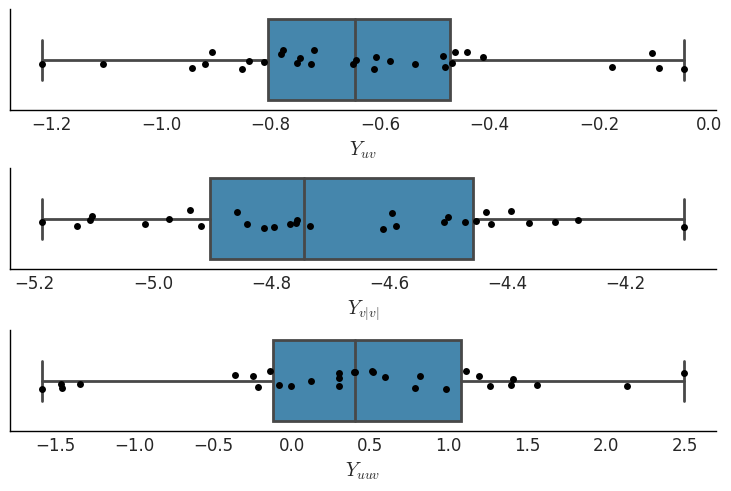

In [20]:
fig,axes=plt.subplots(nrows=len(df_parameter_variation.columns))

for ax,key in zip(axes,df_parameter_variation.columns):
    sns.boxplot(x=df_parameter_variation[key], ax=ax)
    sns.stripplot(x=df_parameter_variation[key], color='black', ax=ax)
    ax.set_xlabel(columns_latex[key])
    
plt.tight_layout()
glue("boxplots",fig, display=False)

In [21]:
_ = []
for index,variation in df_parameter_variation.iterrows():
    
    df_predict_ = df_[['V','beta_deg']].copy()
    df_predict_['fy'] = run(function=lambda_sway, inputs=df_, l=shipdict.main_data['l'], disp=shipdict.design_particulars['disp'], **variation)
    df_predict_[variation.index] = variation
    df_predict_['variation'] = index
    _.append(df_predict_)
    
df_parameter_variation_predictions = pd.concat(_)

Predictions with these alternative models are shown in {numref}`variations` together with the data and the most probable OLS estimate. 
```{glue:figure} variations
:name: "variations"

Monte-Carlo simulations of alternative realizations of the derivatives from the OLS regression.
```

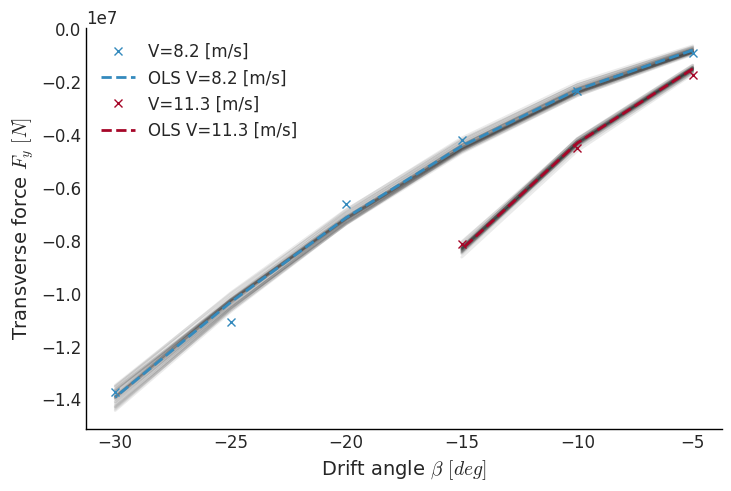

In [22]:
fig,ax=plt.subplots()
for V_, group in df_predict.groupby(by='V'):
    plot = group.plot(x='beta_deg', y='fy', style='x', label=f"V={np.round(V_,decimals=1)} [m/s]", ax=ax)
    color = plot.lines[-1].get_color()
    group.plot(x='beta_deg', y='fy_ols', style='--', color=color, label=f"OLS V={np.round(V_,decimals=1)} [m/s]", zorder=-10, ax=ax)

    for variation, group_variation in df_parameter_variation_predictions.groupby(by='variation'):
        mask = group_variation['V'] == V_
        group_variation.loc[mask].plot(x='beta_deg', y='fy', style='-', color='black', label=f"__none__", zorder=-20, ax=ax, alpha=0.08)
    
    ax.set_xlabel(r'Drift angle $\beta$ $[deg]$')
ax.set_ylabel(r'Transverse force $F_y$ $[N]$');

glue("variations",fig, display=False)

## Conclusions
It has been shown that due to multicollinearity, very different parameter estimations of the multiple linear regression problem can give almost the same prediction accuracy. However, only one of the models can be the correct one - having the correct estimation of the hydrodynamic derivatives as a fair representation of the underlying physics. One option to handle this problem would be to gather more data - till a satisfactory confidence level can be achieved in the estimatimated parameters.

Another option is to reason about the estimated parameter values. Is there any prior knowledge about these parameters, that can be used to rule out some of the solutions? For instance: perhaps we know that $Y_{uv}<0$ based on our prior understanding about hydrodynamics - so that a positive drift angle $\beta$ will always produce a positive lift force from the hull. How this kind of prior knowledge can be incorporated into the regression with Bayesian inference will be discussed in the next section.